# Hello

## Name of the topic is "Finding US cities similar to Phoenix"

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import folium
import requests

# First, I have imported the cities data using Pandas into a dataframe

### From the list of 1000 cities, I have selected the top 50 cities based on population rank This is done in order to minimize the number of API calls

In [11]:
data_raw = pd.read_csv('us_cities.csv', encoding='ISO-8859-1')
top_cities = data_raw[data_raw['Rank']<51].sort_values(by=['Rank'])
top_cities.head()

,City,Rank,State,Growth From 2000 to 2013,Population,lat,lon
67,New York,1,New York,4.8,8405837,40.712784,-74.005941
591,Los Angeles,2,California,4.8,3884307,34.052234,-118.243685
602,Chicago,3,Illinois,-6.1,2718782,41.878114,-87.629798
70,Houston,4,Texas,11.0,2195914,29.760427,-95.369803
674,Philadelphia,5,Pennsylvania,2.6,1553165,39.952584,-75.165222


# Next, I use the FourSquare API to get venue details

In [12]:
CLIENT_ID = 'DXQ1YUUJINSDWH5IKHURSVTZN0IPKU4WPWBXNWVL0E1FKWYK' # your Foursquare ID
CLIENT_SECRET = '4HIOYYAJKGGA4UKFSEVSZVLWHL4IWFIBBLQXDOX1TCMFY14R' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
venues_list = []

for _, row in top_cities.iterrows():
    
    lat = row['lat']
    lng = row['lon']
    city = row['City']
    state = row['State']
    
    

    LIMIT = 10
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION,
        lat, lng, 1000, LIMIT)

    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
#     print(venues[0]['venue']['location']['lng'])
    venues_list.append(
        [
            (city, state, lat, lng, v['venue']['name'], v['venue']['location']['lat'],
             v['venue']['location']['lng'],  v['venue']['categories'][0]['shortName']) 
         for v in venues])

KeyError: 'groups'

# I now load the FourSquare data into a dataframe

In [13]:
nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['City',
                    'State', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

print(nearby_venues.head())

       City     State  Neighborhood Latitude  Neighborhood Longitude  \
0  New York  New York              40.712784              -74.005941   
1  New York  New York              40.712784              -74.005941   
2  New York  New York              40.712784              -74.005941   
3  New York  New York              40.712784              -74.005941   
4  New York  New York              40.712784              -74.005941   

                            Venue  Venue Latitude  Venue Longitude  \
0    The Bar Room at Temple Court       40.711448       -74.006802   
1  THE BEEKMAN - A Thompson Hotel       40.711173       -74.006702   
2                  City Hall Park       40.712241       -74.006977   
3                       Augustine       40.711310       -74.006660   
4                 The Wooly Daily       40.712137       -74.008395   

  Venue Category  
0      Hotel Bar  
1          Hotel  
2           Park  
3         French  
4    Coffee Shop  


In [14]:
usa_venues = nearby_venues.copy()


# one hot encoding
usa_onehot = pd.get_dummies(usa_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
usa_onehot['City'] = usa_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [usa_onehot.columns[-1]] + list(usa_onehot.columns[:-1])
usa_onehot = usa_onehot[fixed_columns]

print(usa_onehot.shape)
usa_onehot.head()

(390, 131)


,City,American,Apparel,Arcade,Argentinian,Art Gallery,Art Museum,Asian,B & B,Bakery,...,Thai,Theater,Used Bookstore,Vegetarian / Vegan,Wine Bar,Wine Shop,Wings,Yoga Studio,Yogurt,Zoo
0,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
usa_grouped = usa_onehot.groupby('City').mean().reset_index()

print(usa_grouped.shape)
usa_grouped.head()

(39, 131)


,City,American,Apparel,Arcade,Argentinian,Art Gallery,Art Museum,Asian,B & B,Bakery,...,Thai,Theater,Used Bookstore,Vegetarian / Vegan,Wine Bar,Wine Shop,Wings,Yoga Studio,Yogurt,Zoo
0,Albuquerque,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0
1,Austin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Baltimore,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Boston,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Charlotte,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# The data is now clustered using the K-means algorithm

## I selected k as 5 since we have 50 cities, so each cluster would have approximately 10 cities

In [16]:
from sklearn.cluster import KMeans
kclusters = 5

us_grouped_clustering = usa_grouped.drop('City', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(us_grouped_clustering)

usa_grouped['label'] = kmeans.labels_

# Now, I use the cluster labels to find the cities similar to Phoenix

## The cities that have the same label as Phoenix are extracted

In [17]:
phoenix_label = int(usa_grouped[usa_grouped['City']=="Phoenix"]['label'])
print(usa_grouped[usa_grouped['label']==phoenix_label]['City'])

0       Albuquerque
4         Charlotte
8            Denver
9           Detroit
10          El Paso
11       Fort Worth
12           Fresno
14     Indianapolis
16      Kansas City
17        Las Vegas
18       Long Beach
21          Memphis
22             Mesa
24        Nashville
28          Phoenix
30       Sacramento
33    San Francisco
34         San Jose
35          Seattle
36           Tucson
Name: City, dtype: object


# Next, I perform PCA and plot the results

## I use PCA to reduce the data to 2 dimensions, so that it can be plotted

### The color of the dot represents the cluster label

### The plot reveals how cities in a given cluster tend to plotted close to each other even in 2D

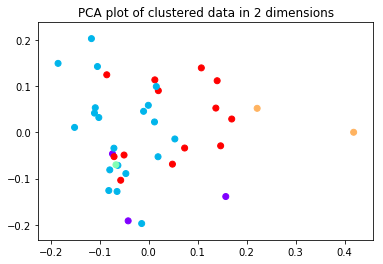

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(us_grouped_clustering)

xs_plot = pca_data.T[0]
ys_plot = pca_data.T[1]

plt.scatter(xs_plot, ys_plot, cmap='rainbow', c=kmeans.labels_)
plt.title("PCA plot of clustered data in 2 dimensions")
plt.show()

# Finally, I plot the data on the map using Folium

## Cities similar to Phoenix (including Phoenix) are marked with large circular markers

## Cities in other clusters are marked with smaller dots

In [19]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

usa_plot = pd.merge(usa_grouped, top_cities, how='left',on='City', validate="1:1")
usa_plot.head()

mycolors = ["#FF0000","#00FF00","#0000FF","#00000F","#00FFFF"]

usmap = folium.Map(location=[37.0902, -95.7129], zoom_start=5)
for lat, lon, city, label in zip(usa_plot['lat'], usa_plot['lon'], 
                                       usa_plot['City'], usa_plot['label']):
    if label == phoenix_label:
        pop = folium.Popup("City Name: "+str(city))
        folium.CircleMarker(
        [lat, lon],
        radius = 7,
        color = mycolors[label],
        fill = True,
        popup = pop,
        fill_color = mycolors[label],
        fill_opacity = 0.3
        ).add_to(usmap)
    else:
        pop = folium.Popup("City Name: "+str(city))
        folium.CircleMarker(
        [lat, lon],
        radius = 2,
        color = mycolors[label],
        fill = True,
        popup = pop,
        fill_color = mycolors[label],
        fill_opacity = 0.3
        ).add_to(usmap)


usmap